In [5]:
import pandas as pd
import os
import numpy as np 
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import sys
import cufflinks as cf
import matplotlib.pyplot as plt
import re
import pydot
from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import SGD, Adam
from keras.utils import plot_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.layers import Flatten
from sklearn import metrics

In [4]:
# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline(connected=True)

#--NotebookApp.iopub_msg_rate_limit = 500

In [5]:
path = 'C:\\Users\\tiamk\\Documents\\Python Scripts\\Grab\\Data\\safety\\features'
os.chdir(path)

In [6]:
def list_files(prefix):
    files = []
    regex = re.compile(prefix + '.*') #String matching
    for file in os.listdir(): #Extract all file in the directroy
        if regex.match(file): #Match the file based on the regex
            if file[-4:] == '.csv': #Ensure it is in csv format
                files.append(file) #Append the file to files
                
    return files

In [7]:
def concat(files):
    dflist = []
    for file in files:
        df = pd.read_csv(file, sep=',', header = 0)
        dflist.append(df)

    concatdf = pd.concat(dflist, axis = 0, ignore_index = True)
    
    return concatdf

In [8]:
def Labeling_dataset(df_feature_0, df_label):
    
    booking_unique = df_feature_0['bookingID'].unique().tolist() # Take the unique value and convert to list
    df_feature_0_copy = df_feature_0.copy() # Create a copy of the dataframe
    df = pd.DataFrame(columns = df_feature_0_copy.columns) # Set the columns of the dataframe

    for i in booking_unique:
        df_label_unique = df_label[df_label['bookingID']==i] # Extract the label dataframe based on the unique value
        df_label_value = df_label_unique['label'].values # Take the label value

        df_feature = df_feature_0_copy[df_feature_0_copy['bookingID']==i] # Extract the feature dataframe based on the unique value
        df_feature['label'] = df_label_value[0] # Create a label column

        df = pd.concat([df, df_feature]) # Concatenate A new dataframe with the label

    df = df[['bookingID', 'Accuracy', 'Bearing', 'Speed', 'acceleration_x', 'acceleration_y',
                         'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'label']] # Rearrange the columns in the new dataframe

    df = df.sort_index() # sort according to index

    return df
#df.to_csv('Feature_Extracted.csv')

In [9]:
def feature_extraction(df):
    
    df_feature = df.iloc[:, 1:11] # Extract certain features from the feature dataframe based on columns
    data = df_feature.values # Take the values of the feature dataframe
    data_label = df.label.values # Take the values of the label dataframe
    
    return data, data_label

In [10]:
def reduce_feature_dimensionality_extraction(df):
    
    # Reduce Dimensionality of acceleration and Gyro
    df_feature = df.iloc[:, 1:11] # Extract certain features from the feature dataframe based on columns
    df_feature_acc = df.iloc[:, 4:7] # Extract acceleration features from the feature dataframe based on columns
    df_feature_gyro = df.iloc[:, 7:10] # Extract Gyro features from the feature dataframe based on columns

    pca = PCA(n_components = 1) # reduce dimensionality with PCA to 1 components
    pca.fit(df_feature_acc)
    data_acc = pca.transform(df_feature_acc)

    pca = PCA(n_components = 1) # reduce dimensionality with PCA to 1 components
    pca.fit(df_feature_gyro)
    data_gy = pca.transform(df_feature_gyro)

    df_feature['Acc_pca'] = data_acc # Create a new columns for PCA result in the feature dataframe
    df_feature['Gyro_pca'] = data_gy # Create a new columns for PCA result in the feature dataframe

    df_feature_new = df_feature.drop(['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z'], axis = 1) #Drop Unneccessary features
    
    data = df_feature_new.values # Take the values of the feature dataframe
    data_label = df.label.values # Take the values of the label dataframe
    
    return data, data_label

In [11]:
# Create reproducibility 
np.random.seed(42)

In [12]:
def standardscaler(data):
    
    sc = StandardScaler() # StandardScaler lib
    data = sc.fit_transform(data) # fit & transform data based on standard scaler
    
    return data

In [13]:
def MinMaxscaler(data):
    
    M_sc = MinMaxScaler() # MinMaxScaler lib
    data = M_sc.fit_transform(data) # fit & transform data based on MinMax scaler
    
    return data

In [14]:
def train_test_split(data, data_label):

    train_size = int(len(data) * 0.67) # Create train size data of 67%
    test_size = len(data) - train_size # Create test size data of 33%
    train, test = data[0:train_size,:], data[train_size:len(data),:] # Split train and test data
    #print(len(train), len(test))

    train_size_label = int(len(data_label) * 0.67) # Create train size data of 67%
    test_size_label = len(data_label) - train_size_label # Create test size data of 33%
    train_label, test_label = data_label[0:train_size_label], data_label[train_size_label:len(data_label)] # Split train and test data
    #print(len(train_label), len(test_label))
    
    return train, test, train_label, test_label

In [15]:
def reshape(trainX, testX):
    
    # reshape input to be [samples, time steps, features]
    trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1])) 
    testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
    
    return trainX, testX

In [2]:
def Convolutional1D_model():
    
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(1, 6)))
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    #model.add(Dropout(0.5))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', metrics = ['acc'], optimizer=adam)
    # lrate = initial_lrate * (1 / (1 + decay * iteration))
    
    return model

In [1]:
def Convolutional1D_SGD_model(learning_rate, epochs):
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 6)))
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    learning_rate = 0.1
    decay_rate = learning_rate / epochs
    momentum = 0.8
    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss='binary_crossentropy', metrics = ['acc'], optimizer = sgd)
    # lrate = initial_lrate * (1 / (1 + decay * iteration))
    
    return model

In [18]:
def Model_plotting():
    plt.figure(figsize=(12,12))

    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

    plt.subplot(222)
    plt.plot(history.history['acc'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()

    plt.subplot(223)
    plt.plot(history.history['val_loss'])
    plt.title('Val_Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Val_Loss')
    plt.grid()

    plt.subplot(224)
    plt.plot(history.history['val_acc'])
    plt.title('Val_Accuracy')
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Val_Accuracy')
    
    return plt

In [40]:
def Model_Predict_plotting(Pred, label,  start, end):
    
    plt.figure(figsize = (20, 10))
    
    plt.subplot(211)
    plt.plot(Pred[start:end], color = 'red', marker = '.')
    plt.xlabel('Range')
    plt.ylabel('Pred')
    plt.title('Prediction result')
    plt.grid()
    
    plt.subplot(212)
    plt.plot(label[start:end], marker = '.')
    plt.title('Actual Result')
    plt.xlabel('Range')
    plt.ylabel('Label')
    plt.grid()

In [20]:
df_feature_0 = pd.read_csv('part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
df_label = pd.read_csv('part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

df = Labeling_dataset(df_feature_0, df_label)


C:\Users\tiamk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [21]:
data, data_label = reduce_feature_dimensionality_extraction(df)
data = standardscaler(data)
trainX, testX, trainY, testY = train_test_split(data, data_label)
trainX_knn, testX_knn, trainY_knn, testY_knn = train_test_split(data, data_label)
trainX, testX = reshape(trainX, testX)

In [7]:
model_conv = Convolutional1D_model()
model_conv.summary()
plot_model(model_conv, to_file='model.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1, 128)            896       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 128)            16512     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 64)             8256      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1, 128)            8320      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 1, 50)             6450      
__________

In [23]:
history = model_conv.fit(trainX, trainY, epochs = 150, batch_size=256, validation_data = (testX, testY), verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 1081081 samples, validate on 532473 samples
Epoch 1/150
 - 54s - loss: 0.6103 - acc: 0.6980 - val_loss: 0.6086 - val_acc: 0.6996
Epoch 2/150
 - 53s - loss: 0.6086 - acc: 0.6997 - val_loss: 0.6082 - val_acc: 0.6997
Epoch 3/150
 - 53s - loss: 0.6080 - acc: 0.7003 - val_loss: 0.6078 - val_acc: 0.7006
Epoch 4/150
 - 53s - loss: 0.6076 - acc: 0.7007 - val_loss: 0.6077 - val_acc: 0.7000
Epoch 5/150
 - 54s - loss: 0.6073 - acc: 0.7011 - val_loss: 0.6071 - val_acc: 0.7008
Epoch 6/150
 - 54s - loss: 0.6070 - acc: 0.7012 - val_loss: 0.6067 - val_acc: 0.7011
Epoch 7/150
 - 54s - loss: 0.6068 - acc: 0.7013 - val_loss: 0.6078 - val_acc: 0.6998
Epoch 8/150
 - 55s - loss: 0.6066 - acc: 0.7013 - val_loss: 0.6071 - val_acc: 0.7013
Epoch 9/150
 - 55s - loss: 0.6064 - acc: 0.7017 - val_loss: 0.6061 - val_acc: 0.7018
Epoch 10/150
 - 55s - loss: 0.6060 - acc: 0.7019 - val_loss: 0.6063 - val_acc: 0.7015
Epoch 11/150
 - 55s - loss: 0.6053 - acc: 0.7019

In [27]:
evaluation = model_conv.evaluate(testX, testY)
pred = model_conv.predict(testX)

532473/532473 [==============================] - 36s 68us/step


<module 'matplotlib.pyplot' from 'C:\\Users\\tiamk\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

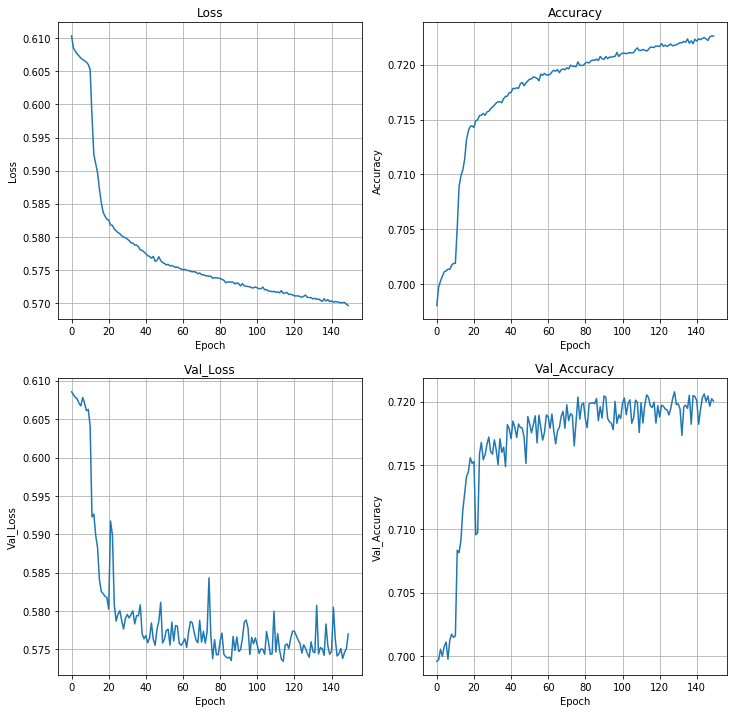

In [28]:
Model_plotting()

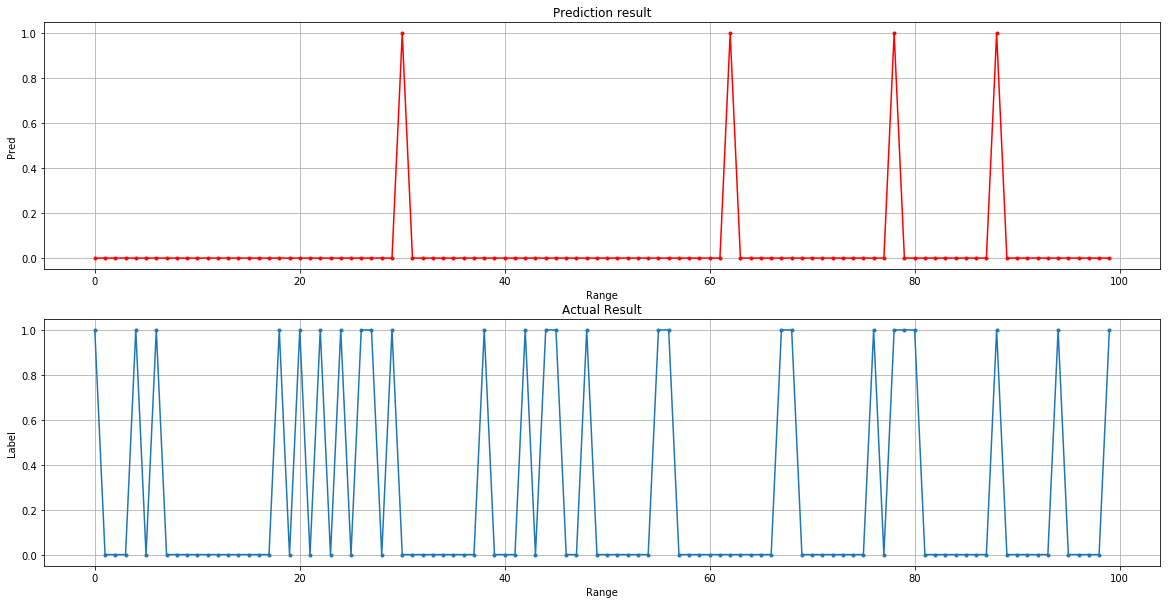

In [45]:
Model_Predict_plotting(pred.round(), testY, 0, 100)